## Logistic Regression News Classifier Model

In [1]:
from collections import defaultdict
import pandas as pd
import math
import re
from sklearn.metrics import f1_score
# from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score

class NewsClassifier:
    def __init__(self, train_path='./raw_data/fulltrain.csv', test_path='./raw_data/balancedtest.csv', target_sample_size=10000, lr_iter=3000, mlp_iter=10, net_architecture=(25,10)):
        # Read CSV file in
        self.df = pd.read_csv(train_path, header=None)
        self.test_df = pd.read_csv(test_path, header=None)

        # Training
        self.target_sample_size = target_sample_size
        self.lr_iter = lr_iter
        self.mlp_iter = mlp_iter
        self.net_architecture = net_architecture
        # Rebalanced dataframe
        self.balanced_df = ''
        self.class_labels = [1,2,3,4]
        self.stopwords = set(stopwords.words('english'))

        # Trained LR model
        self.lr_model = ''
        # Trained MLP model
        self.mlp_model = ''

        # Feature extracted training data - Each element is an array of features in numbers
        self.X_train = ''
        self.y_train = ''

        # Feature extracted test data
        self.Y_balanced_test = self.test_df[0]
        self.X_balanced_test = ''

    # Returns number of each class label
    def count_classes(self, df):
        label_counts = defaultdict(lambda: 0)
        # Labels are first row of DF
        labels = df[0]
        for label in labels:
            label_counts[label] += 1
        return label_counts

    def undersample_data(self, samples, target_size):
        return samples.sample(target_size)

    def oversample_data(self, samples, target_size):
        return samples.sample(target_size, replace=True)

    # Does over and undersampling to achieve targeted dataset size
    def balance_datasets(self, current_counts):
        target_size = self.target_sample_size
        new_samples = []
        for label in self.class_labels:
            samples = self.df[self.df[0] == label]
            if current_counts[label] == target_size:
                samples = samples
            elif current_counts[label] > target_size:
                # Undersample
                samples = self.undersample_data(samples, target_size)
            elif current_counts[label] < target_size:
                # Oversample
                samples = self.oversample_data(samples, target_size)
            new_samples.append(samples)
        print('Resampled')
        return pd.concat(new_samples, axis=0)

    # Do over and undersampling to 10k each
    def prepare_training_data(self):
        print('Preparing training data...')
        label_counts = self.count_classes(self.df)
        print("Label counts: " + str(dict(label_counts)))
        self.balanced_df = self.balance_datasets(label_counts)
        label_counts = self.count_classes(self.balanced_df)
        print("Resampled Label counts: " + str(dict(label_counts)))

    def count_and_remove_stopwords(self, tokens):
        count = 0
        no_stopword_tokens = []
        for token in tokens:
            if token in self.stopwords:
                count += 1
                continue
            no_stopword_tokens.append(token)
        return (count, no_stopword_tokens)

    def tag_with_pos_and_count(self, tokens):
        pos_counts = defaultdict(lambda: 0)
        tagged_tokens = nltk.pos_tag(tokens)
        for token in tagged_tokens:
            pos_counts[token[1]] += 1
        return pos_counts

    def identify_and_count_contractions(self, tokens):
        contraction_pattern = re.compile(r'\w*\'\w*')
        contractions_dict = defaultdict(lambda: 0)
        contraction_count = 0
        for token in tokens:
            if contraction_pattern.match(token):
                contractions_dict[token] += 1
                contraction_count += 1
        return (contraction_count, contractions_dict)

    def identify_and_count_pov_words(self, tokens):
        first_pov_words = ['i', 'me', 'my', 'mine', 'myself', 'ourself', 'ourselves']
        second_pov_words = ['you', 'yours', 'yourself', 'yourselves']
        third_pov_words = ['he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves']
        
        # Need to keep in order
        pov_word_counts = { 1:0, 2:0, 3:0 }
        for token in tokens:
            if token in first_pov_words:
                pov_word_counts[1] += 1
            elif token in second_pov_words:
                pov_word_counts[2] += 1
            elif token in third_pov_words:
                pov_word_counts[3] += 1
        return pov_word_counts

    # Extracts data from the input strings
    def extract_features_from_data(self, training_data):
        pos_tag_list = ['JJ', 'VBP', 'PRP', 'VBN', 'DT', 'NN', 'IN', 'NNS', '.', 'VBD', 'MD', 'VB', ',', 'RB', 'VBZ', 'TO', 'EX', 'CC', 'VBG', 'CD', 'WDT', 'PRP$', 'WRB', 'JJR', 'UH', 'RBR', 'WP', 'RP', ':', 'POS', 'JJS', 'NNPS', 'PDT', '``', "''", '$', 'RBS', 'FW', 'NNP', 'SYM', 'WP$', '(', ')']
        contraction_list = ["'s", "n't", "'re", "'ve", "'m", "'ll", "'d"]
        extracted_features = []

        # Load in entire sample of texts
        texts = training_data[1]

        print('Extracting features...')
        # Start feature extraction
        row_count = 0
        for text in texts:
            print('Extracting features for number: ' + str(row_count), end = "\r")
            row_count += 1
            features = []
            # Initialise POS counter with list of tags to look for
            pos_tag_counts = dict.fromkeys(pos_tag_list, 0)
            contraction_counts = dict.fromkeys(contraction_list, 0)

            # Start with tokenisation
            text = text.lower()
            tokens = nltk.word_tokenize(text)
            # Feature one, length of document
            document_length = len(tokens)
            if document_length == 0:
                features.append(0)
            else:
                features.append(math.log(len(tokens)) + 1)

            stopword_count_and_remove_result = self.count_and_remove_stopwords(tokens)
            stopword_count = stopword_count_and_remove_result[0]
            # Token list with no stop words
            no_stopword_tokens = stopword_count_and_remove_result[1]
            # Add stopword_count to feature list
            if stopword_count == 0:
                features.append(0)
            else:
                features.append(math.log(stopword_count) + 1)

            # Do POS tagging and counts
            pos_counts = self.tag_with_pos_and_count(tokens)
            for key, value in pos_counts.items():
                if key in pos_tag_counts.keys():
                    pos_tag_counts[key] += value
            # Add counts of ALL tags into the feature list
            for key, value in pos_tag_counts.items():
                features.append(value)

            # Count contractions - id:0 == count of contractions, print id:1 for dictionary of each type of contraction
            contraction_identify_and_count_result = self.identify_and_count_contractions(tokens)
            identified_contractions = contraction_identify_and_count_result[1]
            for key, value in identified_contractions.items():
                if key in contraction_counts.keys():
                    contraction_counts[key] += value
            # Add counts of specified contractions into the feature list
            for key, value in contraction_counts.items():
                features.append(value)

            # Get POV word counts
            pov_word_counts = self.identify_and_count_pov_words(tokens)
            # Append into feature list
            for key, value in pov_word_counts.items():
                features.append(value)

            # NO MORE FEATURES TO ADD - Append array into extracted features (2D array)
            extracted_features.append(features)
        print()
        print('Feature extraction done!')
        return extracted_features

    def predict(self, X_test, model):
        predictions = []
        print('Making predictions...')
        for test_data in X_test:
            data = [test_data]
            prediction = model.predict(data)
            predictions.append(prediction[0])
        print('Predictions done!')
        return predictions

    def score_model(self, predictions, target_value):
        score = f1_score(target_value, predictions, average='macro')
        print('F1 score = {}'.format(score))
        accuracy = accuracy_score(target_value, predictions)
        print('Accuracy = {}'.format(accuracy))
        precision = precision_score(target_value, predictions, average='micro')
        print('Precision = {}'.format(precision))
        print()

    # Does feature engineering to return a 2D array, where each element is a summary of all the features
    def create_training_data(self):
        print('Creating training data...')
        # Does over and undersampling on the training dataset
        self.prepare_training_data()
        # training features
        self.X_train = self.extract_features_from_data(self.balanced_df)
        # training outcome
        self.y_train = self.balanced_df[0]

    # Extracts features from balanced_test.csv
    def create_test_data(self):
        print('Creating test data...')
        self.X_balanced_test = self.extract_features_from_data(self.test_df)

    # Print confusion matrix
    def print_confusion_matrix(self, predictions, true_labels, model):
        cm = confusion_matrix(true_labels, predictions, labels=model.classes_)
        cm_plot = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=model.classes_)
        cm_plot.plot()
        cm_plot.show()

    def train_nb_model(self):
        # Naive Bayes Model
        print('=====================================================================================')
        model = MultinomialNB()
        print('Training NB model...')
        model.fit(self.X_train, self.y_train)
        self.lr_model = model
        print('NB Model training done!')

        # Test on training set
        print('Test NB on training set')
        y_train_pred = self.predict(self.X_train, model)
        self.score_model(y_train_pred, self.y_train)
        self.print_confusion_matrix(y_train_pred, self.y_train, model)

        # Test on 'balancedtest.csv'
        print('Test NB on balanced_test.csv')
        y_balancedtest_pred = self.predict(self.X_balanced_test, model)
        self.score_model(y_balancedtest_pred, self.Y_balanced_test)
        self.print_confusion_matrix(y_balancedtest_pred, self.Y_balanced_test, model)
        print('=====================================================================================')

    def train_lr_model(self):
        # Logistic Regression Model: with iter = 5000, 0.3616 score
        print('=====================================================================================')
        model = LogisticRegression(max_iter=self.lr_iter)
        print('Training LR model...')
        model.fit(self.X_train, self.y_train)
        self.lr_model = model
        print('LR Model training done!')

        # Test on training set
        print('Test LR on training set')
        y_train_pred = self.predict(self.X_train, model)
        self.score_model(y_train_pred, self.y_train)
        self.print_confusion_matrix(y_train_pred, self.y_train, model)

        # Test on 'balancedtest.csv'
        print('Test LR on balanced_test.csv')
        y_balancedtest_pred = self.predict(self.X_balanced_test, model)
        self.score_model(y_balancedtest_pred, self.Y_balanced_test)
        self.print_confusion_matrix(y_balancedtest_pred, self.Y_balanced_test, model)
        print('=====================================================================================')

    def train_mlp_model(self):
        # MLP (Multi layer perceptron) model: initial 25,10 - 10 iterations gives 0.4229 score
        print('=====================================================================================')
        model = MLPClassifier(solver='adam', hidden_layer_sizes=self.net_architecture, alpha=1e-5, random_state=1, batch_size=200, max_iter=self.mlp_iter)
        print('Training MLP model...')
        model.fit(self.X_train, self.y_train)
        self.mlp_model = model
        print('MLP Model training done!')

        # Test on training set
        print('Test MLP on training set')
        y_train_pred = self.predict(self.X_train, model)
        self.score_model(y_train_pred, self.y_train)
        self.print_confusion_matrix(y_train_pred, self.y_train, model)

        # Test on 'balancedtest.csv'
        print('Test MLP on balanced_test.csv')
        y_balancedtest_pred = self.predict(self.X_balanced_test, model)
        self.score_model(y_balancedtest_pred, self.Y_balanced_test)
        self.print_confusion_matrix(y_train_pred, self.y_train, model)
        print('=====================================================================================')

Creating training data...
Preparing training data...
Label counts: {1: 14047, 2: 6942, 3: 17870, 4: 9995}
Resampled
Resampled Label counts: {1: 10000, 2: 10000, 3: 10000, 4: 10000}
Extracting features...
Extracting features for number: 39999
Feature extraction done!
Creating test data...
Extracting features...
Extracting features for number: 2999
Feature extraction done!
Training LR model...


C:\Users\dojh1\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Model training done!
Test LR on training set
Making predictions...
Predictions done!
score on validation = 0.8644932770340981

Test LR on balanced_test.csv
Making predictions...
Predictions done!
score on validation = 0.37330712832569074

Training MLP model...


C:\Users\dojh1\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (12) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP Model training done!
Test LR on training set
Making predictions...
Predictions done!
score on validation = 0.8978267332878057

Test MLP on balanced_test.csv
Making predictions...
Predictions done!
score on validation = 0.3966273034103894



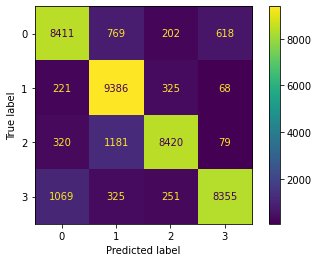

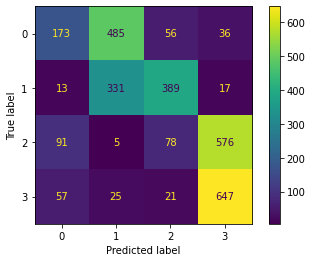

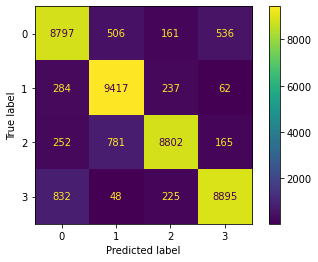

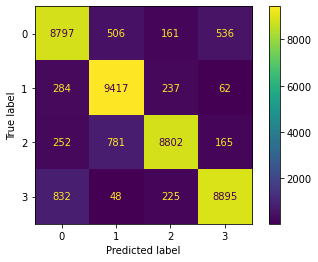

In [2]:
# Set up feature engineered test and training data - BASELINE
news_classifier = NewsClassifier(target_sample_size=10000, lr_iter=500, mlp_iter=12, net_architecture=(20,))
news_classifier.create_training_data()
news_classifier.create_test_data()

news_classifier.train_lr_model()
news_classifier.train_mlp_model()